# Advanced Anomaly Detection

### Load Data

In [1]:
import glob
import pandas as pd

csv_files = glob.glob("data/*.csv")
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

### (a) Statistical Traffic Analysis

#### Statistical Thresholds for Anomalies

We define thresholds for anomalies in three key traffic metrics by computing statistical baselines:

1. **Packet Sizes**
   - Total bytes per flow are calculated using `totalSourceBytes + totalDestinationBytes`.
   - A log-scale histogram is used to visualize the highly skewed distribution.

2. **Flow Counts**
   - Flows are grouped by hourly windows using `startDateTime`.
   - A line plot is used to visualize flow counts over time.

3. **Protocol Distributions**
   - We compute the overall protocol usage as a baseline.
   - Protocol usage is shown as percentages of total flows.

Visualizations are used to explore distribution characteristics before applying anomaly thresholds.

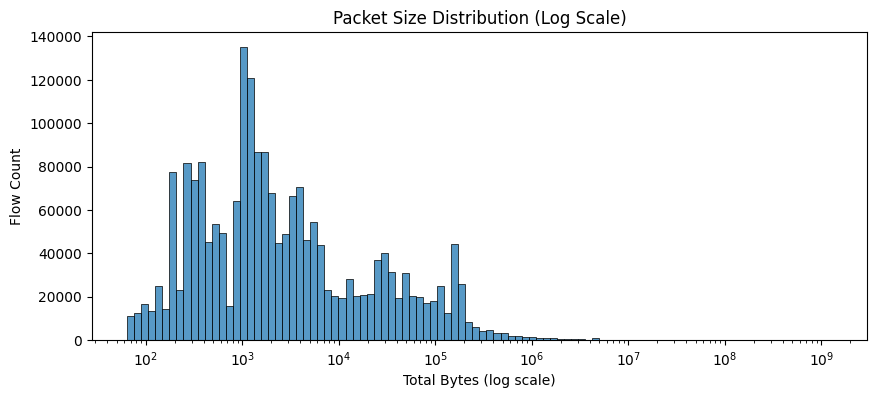

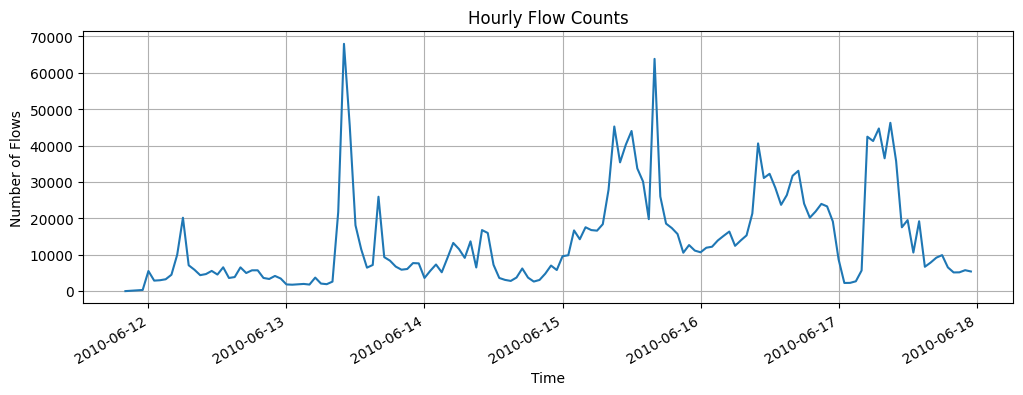

Baseline Protocol Distribution (%):
tcp_ip      79.36
udp_ip      20.24
icmp_ip      0.40
igmp         0.00
ip           0.00
ipv6icmp     0.00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df['startDateTime'] = pd.to_datetime(df['startDateTime'], errors='coerce')
df['totalBytes'] = df['totalSourceBytes'] + df['totalDestinationBytes']

# Log-scale histogram to visualize skewed packet size distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['totalBytes'], bins=100, log_scale=(True, False))
plt.title("Packet Size Distribution (Log Scale)")
plt.xlabel("Total Bytes (log scale)")
plt.ylabel("Flow Count")
plt.show()

# Flow counts per hour
df['hour'] = df['startDateTime'].dt.floor('h')
flows_per_hour = df.groupby('hour').size()

plt.figure(figsize=(12, 4))
flows_per_hour.plot()
plt.title("Hourly Flow Counts")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.grid(True)
plt.show()

# Protocol distribution baseline
protocol_counts = df['protocolName'].value_counts(normalize=True) * 100
print("Baseline Protocol Distribution (%):")
print(protocol_counts.round(2).to_string(header=False))

Statistical thresholds are defined for packet size, flow count (hourly and daily), and protocol distribution. The selection of methods is based on the distribution patterns observed in the data visualizations.

- **Packet Sizes**: The log-scaled histogram shows a long-tailed distribution, making z-score ineffective. IQR is used to identify large flows while minimizing sensitivity to extreme outliers.

- **Flow Counts**: Hourly traffic displays frequent fluctuations, making mean + 2×std a suitable method to flag short-term bursts. Daily totals are also analyzed using the same method to detect sustained volume surges.

- **Protocol Distributions**: The traffic is largely stable with a baseline of ~79% TCP and ~20% UDP. Sudden shifts in these distributions over short time windows are treated as potential anomalies.

In [3]:
q1 = df['totalBytes'].quantile(0.25)
q3 = df['totalBytes'].quantile(0.75)
iqr = q3 - q1
packet_threshold = q3 + 1.5 * iqr

flow_mean = flows_per_hour.mean()
flow_std = flows_per_hour.std()
flow_upper = flow_mean + 2 * flow_std

df['day'] = df['startDateTime'].dt.floor('d')
flows_per_day = df.groupby('day').size()
daily_mean = flows_per_day.mean()
daily_std = flows_per_day.std()
daily_upper = daily_mean + daily_std

print(f"Packet size threshold (IQR): {packet_threshold:.2f} bytes")
print(f"Hourly flow threshold (upper): {flow_upper:.2f} bytes")
print(f"Daily flow threshold (upper): {daily_upper:.2f} bytes")

Packet size threshold (IQR): 19787.50 bytes
Hourly flow threshold (upper): 40416.71 bytes
Daily flow threshold (upper): 507149.29 bytes


#### Temporal Comparison of Traffic Patterns

We compare flow activity across two different time granularities — hourly and daily — to identify significant deviations in volume and pattern.

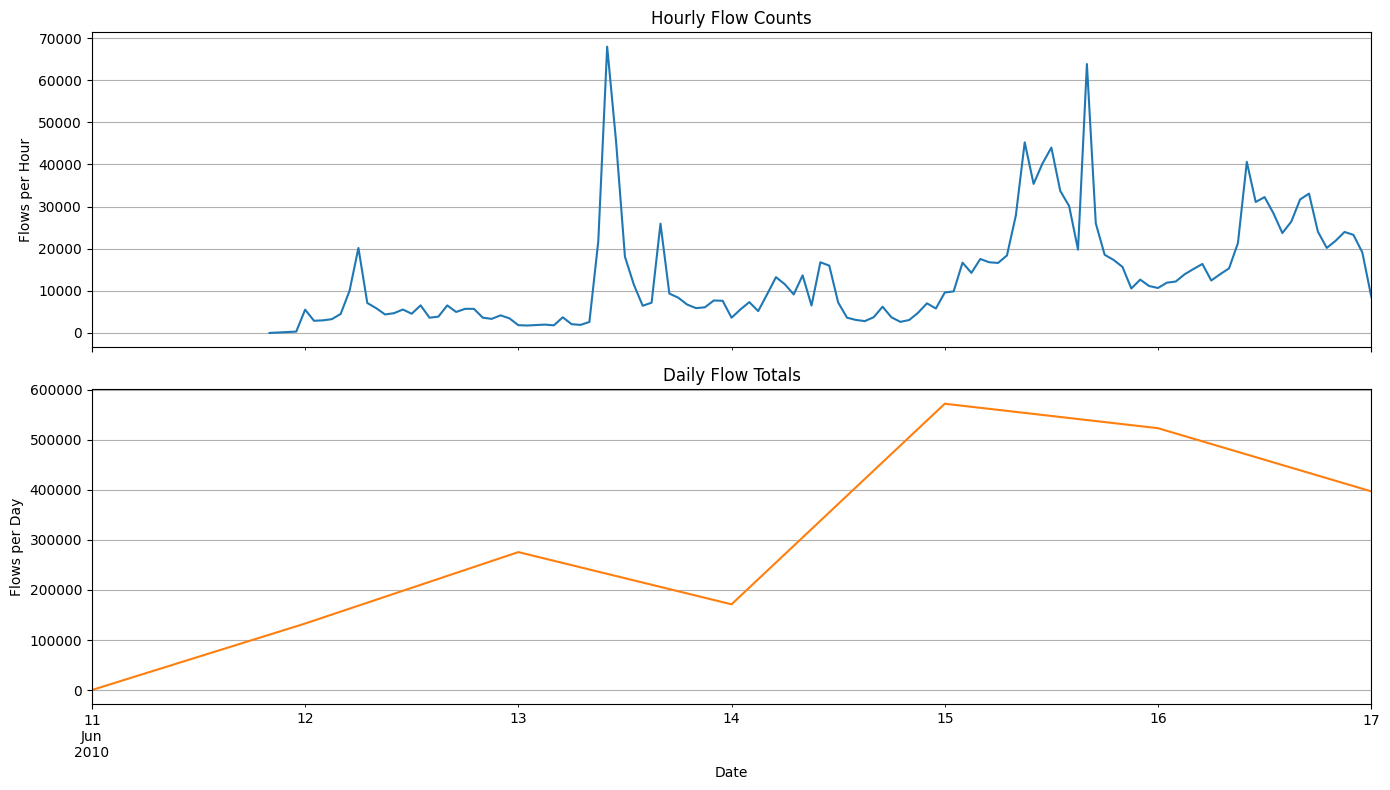

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

flows_per_hour.plot(ax=axs[0], label='Hourly', color='tab:blue')
axs[0].set_title("Hourly Flow Counts")
axs[0].set_ylabel("Flows per Hour")
axs[0].grid(True)

flows_per_day.plot(ax=axs[1], label='Daily', color='tab:orange')
axs[1].set_title("Daily Flow Totals")
axs[1].set_ylabel("Flows per Day")
axs[1].set_xlabel("Date")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [5]:
significant_days = flows_per_day[flows_per_day > daily_upper]

for day in significant_days.index:
    hourly_flows = flows_per_hour[flows_per_hour.index.date == day.date()]
    if hourly_flows.empty:
        continue

    daily_total = flows_per_day[day]
    max_hourly = hourly_flows.max()
    hourly_sum = hourly_flows.sum()
    hourly_std = hourly_flows.std()
    overall_hourly_std = flows_per_hour.std()

    print(f"\nDate: {day.date()}")
    print(f"  Daily total    : {daily_total}")
    print(f"  Max hourly     : {max_hourly}")
    print(f"  Hourly sum     : {hourly_sum}")

    if max_hourly > flow_upper:
        print("  → Anomaly type: Short-term burst (single-hour spike)")
    elif hourly_std > overall_hourly_std:
        print("  → Anomaly type: Fluctuating intra-day behavior")
    else:
        print("  → Anomaly type: Sustained elevated traffic")

normal_days = flows_per_day[flows_per_day <= daily_upper]

for day in normal_days.index:
    hourly_flows = flows_per_hour[flows_per_hour.index.date == day.date()]
    if hourly_flows.empty:
        continue

    max_hour = hourly_flows.max()

    if max_hour > flow_upper:
        print(f"\nDate: {day.date()}")
        print(f"  Daily total    : {flows_per_day[day]}")
        print(f"  Max hourly     : {max_hour}")
        print("  → Hidden anomaly: High hourly spike despite normal daily total")


Date: 2010-06-15
  Daily total    : 571699
  Max hourly     : 63821
  Hourly sum     : 571699
  → Anomaly type: Short-term burst (single-hour spike)

Date: 2010-06-16
  Daily total    : 522896
  Max hourly     : 40588
  Hourly sum     : 522896
  → Anomaly type: Short-term burst (single-hour spike)

Date: 2010-06-13
  Daily total    : 275579
  Max hourly     : 67952
  → Hidden anomaly: High hourly spike despite normal daily total

Date: 2010-06-17
  Daily total    : 396854
  Max hourly     : 46246
  → Hidden anomaly: High hourly spike despite normal daily total


#### Flagging Outlier IPs by Traffic Volume

We group flows by source IP and calculate total bytes sent. To detect abnormal behavior, we apply the IQR method:

- IPs below **Q1 − 1.5×IQR** or above **Q3 + 1.5×IQR** are flagged as outliers.
- This identifies both unusually low and high traffic sources.

This method helps detect misconfigured devices, dormant hosts, or potentially suspicious high-volume traffic without being skewed by extreme values.

In [6]:
source_traffic = df.groupby('source')['totalSourceBytes'].sum()

q1 = source_traffic.quantile(0.25)
q3 = source_traffic.quantile(0.75)
iqr = q3 - q1
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

low_traffic_ips = source_traffic[source_traffic < lower_threshold]
high_traffic_ips = source_traffic[source_traffic > upper_threshold]

print("Low traffic outlier IPs:")
print(low_traffic_ips)

print("\nHigh traffic outlier IPs:")
print(high_traffic_ips)

Low traffic outlier IPs:
Series([], Name: totalSourceBytes, dtype: int64)

High traffic outlier IPs:
source
0.0.0.0            5315
10.64.250.65       2590
109.197.48.50      5350
109.92.108.167     4218
109.93.202.76      5180
                  ...  
98.139.91.72      37258
98.139.91.75      37259
98.139.91.84      37264
98.248.105.184     2294
99.51.237.200      1664
Name: totalSourceBytes, Length: 318, dtype: int64


### (b) Behavioral Analysis (10 Marks)

#### Detecting Sudden Behavioral Changes in IP Activity

This part focuses on identifying source IPs that suddenly change behavior — for example, being inactive for a long period and then suddenly sending a large volume of traffic.

**Approach:**
- Aggregate total bytes sent (`totalSourceBytes`) by each source IP per hour
- For each IP, compute the difference between consecutive hourly traffic
- Flag IPs where a large traffic spike follows an hour of inactivity

**Threshold:**
- A fixed spike threshold (e.g., 50,000 bytes) is used to define a significant jump in traffic
- This provides a simple and interpretable baseline for flagging anomalies

In [7]:
traffic_by_hour = df.groupby(['source', 'hour'])['totalSourceBytes'].sum().unstack(fill_value=0)
traffic_diffs = traffic_by_hour.diff(axis=1).fillna(0)

spike_threshold = 50000
behavioral_spikes = []

for ip in traffic_by_hour.index:
    series = traffic_by_hour.loc[ip]
    diffs = traffic_diffs.loc[ip]
    idle = series == 0
    idle_shifted = idle.shift(1).where(lambda x: x.notna(), True)
    spike = diffs > spike_threshold
    if any(idle_shifted & spike):
        behavioral_spikes.append(ip)

print("IPs with sudden spikes after inactivity:")
print(behavioral_spikes)

IPs with sudden spikes after inactivity:
['131.202.240.209', '131.202.243.90', '142.167.88.44', '187.60.74.67', '192.168.3.115', '192.168.3.117', '192.168.4.121', '192.168.5.124', '65.55.34.12', '67.195.23.154', '67.195.8.62', '67.195.9.84', '67.23.167.37', '80.66.211.179', '98.137.26.79', '98.139.91.71']


#### Flagging Destination IPs Contacted by Many Sources in a Short Time

We identify destination IPs that are contacted by an unusually large number of unique source IPs during a single hour — indicating coordinated or abnormal activity.

**Approach:**
- Count unique source IPs per destination per hour
- Use the IQR method to define a spike threshold
- If IQR is zero (flat distribution), fallback to the 99.5th percentile

**Threshold:**
- Default: Q3 + 1.5 × IQR
- Fallback: 99.5th percentile if no IQR spread

In [8]:
contact_counts = df.groupby(['destination', 'hour'])['source'].nunique().unstack(fill_value=0)

counts_flat = contact_counts.stack()
q1 = counts_flat.quantile(0.25)
q3 = counts_flat.quantile(0.75)
iqr = q3 - q1

if iqr == 0:
    threshold = counts_flat.quantile(0.995)
else:
    threshold = q3 + 1.5 * iqr

anomalies = counts_flat[counts_flat > threshold]
print(anomalies)

destination     hour               
112.78.112.206  2010-06-16 19:00:00    2
115.178.18.2    2010-06-12 05:00:00    2
                2010-06-12 06:00:00    2
                2010-06-13 09:00:00    2
                2010-06-13 10:00:00    3
                                      ..
98.158.176.206  2010-06-13 10:00:00    2
                2010-06-15 10:00:00    2
                2010-06-15 12:00:00    3
                2010-06-15 22:00:00    2
                2010-06-17 08:00:00    2
Length: 19323, dtype: int64


### (c) Suspicious Communication Patterns (5 Marks)

#### Detecting Long-Duration Connections

This analysis flags network flows with unusually long durations, which may indicate persistent sessions, misconfigured hosts, or covert channels.

**Approach:**
- Compute the duration of each flow using `stopDateTime - startDateTime`
- Visualize the distribution of durations using a log-scaled histogram
- Use the IQR method to define a threshold for long connections
- Flag flows where duration exceeds Q3 + 1.5 × IQR

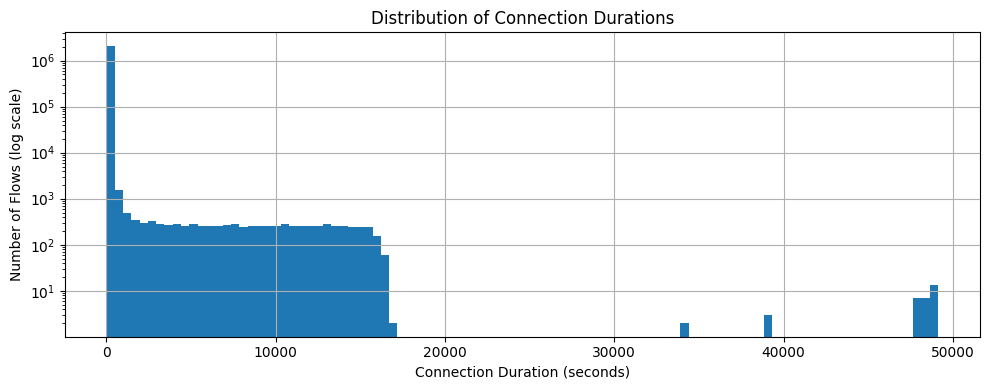

Duration threshold: 480.00 seconds
Number of long-duration flows: 9975

Top 10 longest flows:
       source     destination  duration
192.168.1.101   192.168.1.255   49140.0
192.168.1.101 255.255.255.255   49140.0
192.168.2.109 255.255.255.255   48960.0
192.168.2.109   192.168.2.255   48960.0
192.168.2.112 255.255.255.255   48900.0
192.168.2.112   192.168.2.255   48900.0
192.168.2.112   192.168.2.109   48900.0
192.168.3.114 255.255.255.255   48780.0
192.168.3.114   192.168.3.255   48780.0
192.168.3.117 255.255.255.255   48780.0


In [9]:
df['startDateTime'] = pd.to_datetime(df['startDateTime'])
df['stopDateTime'] = pd.to_datetime(df['stopDateTime'])
df['duration'] = (df['stopDateTime'] - df['startDateTime']).dt.total_seconds()

plt.figure(figsize=(10, 4))
plt.hist(df['duration'], bins=100, log=True)
plt.xlabel("Connection Duration (seconds)")
plt.ylabel("Number of Flows (log scale)")
plt.title("Distribution of Connection Durations")
plt.grid(True)
plt.tight_layout()
plt.show()

q1 = df['duration'].quantile(0.25)
q3 = df['duration'].quantile(0.75)
iqr = q3 - q1

if iqr == 0:
    threshold = df['duration'].quantile(0.995)
else:
    threshold = q3 + 1.5 * iqr

long_flows = df[df['duration'] > threshold]

print(f"Duration threshold: {threshold:.2f} seconds")
print(f"Number of long-duration flows: {len(long_flows)}")
print("\nTop 10 longest flows:")
print(long_flows.sort_values(by='duration', ascending=False)[['source', 'destination', 'duration']].head(10).to_string(index=False))

#### Suspicious IPs Communicating Using Multiple Protocols in a Short Time

This analysis identifies source IPs that use multiple different protocols within a 15-minute time window, which may indicate scanning, evasion, or multi-channel probing.

**Approach:**
- Round timestamps to 15-minute windows
- Group by source IP and time window
- Count how many distinct protocols were used
- Use the IQR method to detect unusually high protocol diversity
- If IQR is 0, fallback to the 99.5th percentile threshold

In [10]:
df['window'] = df['startDateTime'].dt.floor('15min')
proto_counts = df.groupby(['source', 'window'])['protocolName'].nunique()
q1 = proto_counts.quantile(0.25)
q3 = proto_counts.quantile(0.75)
iqr = q3 - q1

if iqr == 0:
    threshold = proto_counts.quantile(0.995)
else:
    threshold = q3 + 1.5 * iqr

suspicious = proto_counts[proto_counts > threshold]
print("Suspicious IPs communicating using multiple protocols in a short time (15 min window):")
print(suspicious.to_string(header=False))

Suspicious IPs communicating using multiple protocols in a short time (15 min window):
192.168.2.107  2010-06-14 21:45:00    4
